# The best raster of all: DEMs
Geospatial Data Analysis, Winter 2019  
3/8/19  
David Shean


## What is a DEM?
DEM = Digital Elevation Model

A generic term for a 2D grid with values representing surface elevation above some datum (e.g., WGS84 ellispoid, a geoid model representing mean sea level).

There are subtypes:
* DSM = Digital Surface Model ("first-return" model includes top of canopy, buildings, etc.)
* DTM = Digital Terrain Model (bare ground model, with canopy, buildings, etc. removed)

## SRTM
SRTM = Shuttle Radar Topography Mission
https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission
https://www2.jpl.nasa.gov/srtm/

This week, we'll play with the landmark SRTM products.
Collected February 11-22, 2000 (winter)
Single-track InSAR (interferometric synthetic aperture radar) instrument
56°S to 60°N (the shuttle LEO orbit) 

### Versions
* SRTM-GL1
* void-filled
* NASADEM

### SRTM tile distribution
* 1-arcsecond (~30 m)
* 3-arcsecond (~90 m)

# Exercises

For this lab, we'll use the 3-arcsec product for WA state.  This is a relatively small dataset, with only two input tiles.  However, the approaches we'll learn, especially vrt operations, scale nicely to larger datasets that are too big to fit in memory.  Feel free to experiment with the 1-arcsec or a larger extent (e.g., Western U.S.)

## Install the `elevation` package to easily download SRTM tiles
* Note that this runs `make` and doesn't play well with OS X or Win

In [1]:
!pip install elevation

In [2]:
import os
import numpy as np
import geopandas as gpd
import elevation
import rasterio
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Get the Washington state bounds from your Week04 notebook

In [4]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

In [5]:
#Set some variables for the SRTM dataset
cache_dir='./elevation'
product='SRTM3'
output='wa_%s_full.tif' % product

## Use the `elevation` module to download tiles
* This may take a few minutes (and hopefully not a problem if everyone tries to do this simultaneously)
* While you wait, open a terminal and navigate to the elevation directory (should be in same subfolder as your notebook)
    * Explore the filestructure and run `gdalinfo` on the tif as they are downloaded and unzipped
* Note that the `elevation` module also has a `clip` function to clip to specified bounds, but we're going to learn how to do this ourselves, as it's a common operation

In [6]:
#elevation.clean(cache_dir=cache_dir)
elevation.seed(bounds=wa_bounds, cache_dir=cache_dir, product=product, max_download_tiles=999)
#elevation.clip(bounds=wa_bounds, output=output, cache_dir=cache_dir, product=product, max_download_tiles=999)

'./elevation/SRTM3'

In [7]:
#srtm_fn = os.path.join(cache_dir, product, output)
#srtm_fn = os.path.join(cache_dir, product, product+'.vrt')

In [8]:
!ls $cache_dir/$product/cache

srtm_12_03.tif	srtm_12_03.tif.lock  srtm_13_03.tif  srtm_13_03.tif.lock


## Create a vrt (virtual file) of the tiles in the cache subdirectory
* Read a bit about vrt (they're a little confusing, but once you get the concept, they're amazing): 
    * https://www.gdal.org/gdal_vrttut.html
    * http://www.perrygeo.com/lazy-raster-processing-with-gdal-vrts.html
* Easy to use the `gdalbuildvrt` command-line utility for this: https://www.gdal.org/gdalbuildvrt.html

In [30]:
vrt_fn = 'shean_srtm_full.vrt'
!gdalbuildvrt $vrt_fn $cache_dir/$product/cache/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


## Use a text editor to review the contents of the output vrt
* Note the total width and height of the vrt (rasterXSize, rasterYSize)
* How many SRTM tiles are in your vrt?  Note the tile width and height of each tile and the `DstRect` offsets.  Take a moment to discuss with your neighbor.  How is each tile placed within the vrt?  What would the values be for the next two tiles from the row to the south?

## Open and plot your vrt
* Note that rasterio and GDAL can both open vrt files as datasets!  This is very useful, as you could have a vrt containing SRTM tiles for the entire planet, and open it in seconds, since you're not actually reading each file, just the vrt "container" that points to all of the individual tif files
    * You can then read only the subwindow that you need
    * This can cross multiple tiles, and GDAL does the work behind the scenes
* Open the vrt with rasterio
* Review the metadata
* Read the data to a NumPy array
    * Note that the tiles on disk are actually loaded when you `read` the dataset
    * Make sure you deal with nodata, either with a NumPy masked array, or setting nodata to np.nan (remember np.nan is a float, your input data type is int16)
* View with matplotlib imshow - verify you have a DEM of washington state

In [10]:
src = rio.open(vrt_fn)

In [11]:
src.profile

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 12001, 'height': 6001, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.0008333333333333334, 0.0, -125.00041606131708,
       0.0, -0.0008333333333333334, 50.000417005657994), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

In [12]:
srtm = src.read(1).astype(float)
srtm[srtm==src.nodata] = np.nan

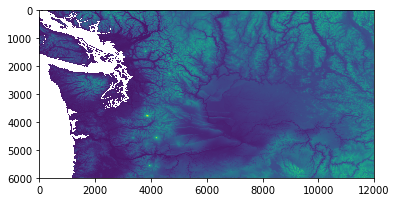

In [13]:
f, ax = plt.subplots()
plt.imshow(srtm)

## Overviews
* https://www.gdal.org/gdaladdo.html
* https://rasterio.readthedocs.io/en/stable/topics/overviews.html

## Use rasterio to reproject from EPSG:4326 to an appropriate coordinate system for WA
* Note that the hgt SRTM tiles are elevations relative to the EGM96 geoid (approximates sea level)
* See example here: https://rasterio.readthedocs.io/en/stable/topics/reproject.html#reprojecting-a-geotiff-dataset
* Define your coordinate system as `dst_crs` variable (needed later)
* Save the projected file as a GeoTiff on disk
    * print the metadata of your input and output datasets
    * If you are copying the metadata from your input dataset (as in the example), you will need to update the 'driver' to 'GTiff' before open the file for writing
        
    * Use cubic resampling algorithm
* Note that you can also use the `gdalwarp` command to do this efficiently on the command line:  
    `gdalwarp -r cubic -t_srs EPSG:32610 srtm.vrt srtm_proj.tif`

In [14]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:32610'
proj_fn = os.path.splitext(vrt_fn)[0]+'_proj_rio.tif'
driver = 'GTiff'
#proj_fn = os.path.splitext(vrt_fn)[0]+'_proj.vrt'
#driver = 'VRT'

if not os.path.exists(proj_fn):
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    print(kwargs)
    kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
    kwargs['driver'] = driver
    kwargs['compress'] = 'LZW'
    kwargs['tiled'] = True
    kwargs['BIGTIFF'] = 'IF_SAFER'
    print(kwargs)
    
    with rasterio.open(proj_fn, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i), destination=rasterio.band(dst, i), src_transform=src.transform,\
                      src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)

In [15]:
#!gdalwarp -r cubic -t_srs EPSG:32610 $vrt_fn $proj_fn

## A note about "creation options" when writing a new file to disk
* https://www.gdal.org/frmt_gtiff.html (a great reference to review, see Creation Options section toward bottom of page)
* I almost always use `-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER`
    * Uses lossless LZW compression (we explored in LS8 example comparing filesize on disk to your calculated array filesize)
    * Writes the image in "tiles" of 512x512 px (user-specified) instead of one large block - makes it much more efficient to extract a subwindow from the tif
    * If necessary, use the BIGTIFF format for files that are >4 GB
* You can specify these configuration options in the `rasterio.open()` kwargs:
    * https://github.com/mapbox/rasterio/blob/master/docs/topics/image_options.rst
    * https://rasterio.readthedocs.io/en/stable/topics/profiles.html
    * https://rasterio.readthedocs.io/en/stable/topics/configuration.html

## Write out the same file, but use tiling and LZW compression
* Compare the filesizes on disk

In [16]:
#!gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -t_srs EPSG:32610 $vrt_fn $proj_fn

## Load your reprojected dataset as an array, sanity check

In [17]:
src_proj = rio.open(proj_fn)

In [18]:
src_proj.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 11299, 'height': 8408, 'count': 1, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(69.75864688326182, 0.0, 342335.42500309506,
       0.0, -69.75864688326182, 5569416.320597215), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [19]:
srtm_proj = src_proj.read(1).astype(float)
srtm_proj[srtm_proj==src_proj.nodata] = np.nan

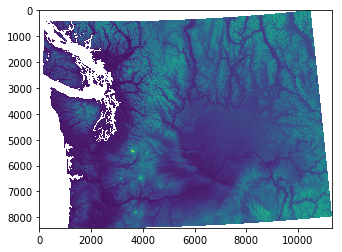

In [20]:
f, ax = plt.subplots()
plt.imshow(srtm_proj)

## Sanity check
* What is the projected x and y cell size?
* Is this consistent with your expectation for the 1-arcsec SRTM data?
    * Hint: think back to Week03 when we calculated length of a degree of longitude and a degree of latitude
* Note that you can specify output resolution in rasterio and for gdalwarp with the `-tr` argument

## Clip the projected DEM to the WA state multipolygon
* This is a common GIS operation
* Some useful resources:
    * https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html
    * https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/crop-raster-data-with-shapefile-in-python/
* Plot with imshow to verify your clip worked!

In [21]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"(POLYGON ((-88.124658 30.28364, -88.0868119999..."
1,0400000US02,02,Alaska,,570640.950,"(POLYGON ((-166.10574 53.988606, -166.075283 5..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33...."
4,0400000US06,06,California,,155779.220,"(POLYGON ((-122.421439 37.869969, -122.421341 ..."


In [22]:
#Reproject to projected coordinate system selected earlier
states_gdf_proj = states_gdf.to_crs({'init':dst_crs})
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

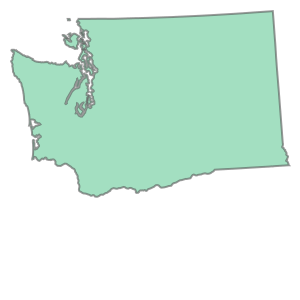

In [23]:
wa_geom

In [24]:
wa_mask, out_transform = rio.mask.mask(src_proj, wa_geom, crop=True)
#wa_mask = wa_mask[0].astype(float)
#wa_mask[wa_mask==src_proj.nodata] = np.nan
wa_mask = np.ma.masked_equal(wa_mask[0], src_proj.nodata)

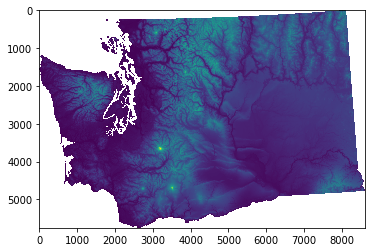

In [25]:
f, ax = plt.subplots()
plt.imshow(wa_mask)

## Do some quick analysis and compute some stats for your clipped array
* What is the minimum, maximum, mean and median elevation for WA state?  Maybe a histogram would be interesting
* What percentage of the state is >1 mile above sea level? 
    * Sorry about the units
    * Remember, that you have a regular grid here, so you know the dimensions in meters of each grid cell
    * This should be done in an equal-area projection, but fine to estimate with UTM if that's what you chose earlier

In [ ]:
mile_elev = 1609.34

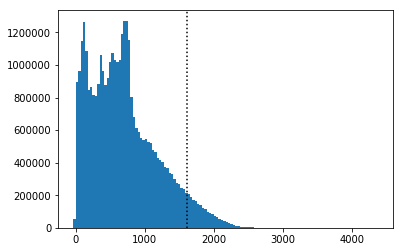

In [58]:
f,ax = plt.subplots()
h = ax.hist(wa_mask.compressed(), bins=128)
ax.axvline(mile_elev, color='k', ls=':')

In [27]:
print(wa_mask.min(), wa_mask.max(), wa_mask.mean(), np.ma.median(wa_mask))

-34 4373 698.9473560112752 634.0


In [28]:
idx = wa_mask.compressed() > mile_elev

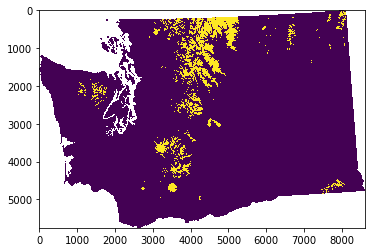

In [57]:
f,ax = plt.subplots()
ax.imshow(wa_mask > mile_elev)

In [29]:
total = wa_mask.compressed().shape[0]

In [30]:
higher = np.count_nonzero(idx)

In [31]:
100*higher/total

5.638757076839033

## Create a shaded relief map (hillshade) from your projected (but unclipped) DEM
* See background info on hillshades here: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
* Can do this easily with `gdaldem` command line utility: https://www.gdal.org/gdaldem.html
    * Try this and output to a new file
    * Note that if attempt to run on a DEM with different horizontal and vertical units, (like say, degrees and meters), you will have scaling issues. This is why we reprojected first
* Can also use GDAL Python API directly
    * Documentation of this functionality is poor, but it's pretty simple (see my example below)
    * Some examples are here: https://github.com/OSGeo/gdal/blob/master/autotest/utilities/test_gdaldem_lib.py
* Load your shaded relief map as a new NumPy masked array (type is Byte, with values from 0-255), want to mask 0 values

In [32]:
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'

In [33]:
!gdaldem hillshade $proj_fn $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [34]:
#Example using GDAL API
"""
from osgeo import gdal
#Open the GDAL dataset
dem_ds = gdal.Open(proj_fn)
#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
producttype = 'hillshade'
#Create a GDAL hillshade dataset in memory
hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', format='MEM')
#Read the dataset as a NumPy array
hs = hs_ds.ReadAsArray()
plt.imshow(hs, cmap='gray')
"""

"\nfrom osgeo import gdal\n#Open the GDAL dataset\ndem_ds = gdal.Open(proj_fn)\n#Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options\nproducttype = 'hillshade'\n#Create a GDAL hillshade dataset in memory\nhs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', format='MEM')\n#Read the dataset as a NumPy array\nhs = hs_ds.ReadAsArray()\nplt.imshow(hs, cmap='gray')\n"

In [35]:
hs_src = rio.open(hs_fn)
hs = np.ma.masked_equal(hs_src.read(1), hs_src.nodata)

In [36]:
hs

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)

## Create a color shaded relief map
* Load both the projected DEM and the shaded relief map as arrays (already did this)
* Use `rio.plot.plotting_extent` to get the projected coordinate extent to feed to matplotlib imshow
* Plot the hillshade array with appropriate extent and 'gray' cmap
* Plot the masked DEM array with appropriate extent (different than full-state hillshade)
    * Use matplotlib alpha for transparency
    * Use a nice color ramp to represent elevations
    * Add a colorbar

Note: your hillshade extent should be larger than your cropped, masked WA DEM!

In [37]:
rio.plot.plotting_extent(wa_mask, out_transform)

(371075.9875189989, 971139.8680088171, 5043505.881744304, 5444548.342676176)

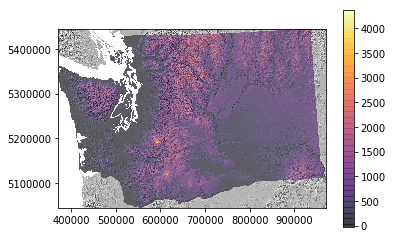

In [72]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(hs_src))
m = ax.imshow(wa_mask, cmap='inferno', extent=rio.plot.plotting_extent(wa_mask, out_transform), alpha=0.5)
plt.colorbar(m, ax=ax)

## Zoom to Mt. Rainier extent from Week07 lab

## Volume estimation

# Sampling a DEM at points

## Load a GeoDataFrame for the WA SNOTEL site locations
* You could go back to your Week06 notebook and export as json
* But I did this for you - there should be a file called `snotel_conus_sites.json` in the assignment repo

In [39]:
#sites_fn = '/home/jovyan/gda_w2019_material/06_Spatiotemporal_vector_SNOTEL/snotel_conus_sites.json'
sites_fn = './snotel_conus_sites.json'
sites_gdf = gpd.read_file(sites_fn)

In [40]:
sites_gdf.head()

,code,name,network,elevation_m,geometry
0,1000_OR_SNTL,Annie Springs,SNOTEL,1831.8,POINT (-122.1652 42.8701)
1,1004_WA_SNTL,Epa Waterhole Can,SNOTEL,1524.0,POINT (-123.7 48.5667)
2,1005_CO_SNTL,Ute Creek,SNOTEL,3246.1,POINT (-105.3733 37.615)
3,1006_NV_SNTL,Lewis Peak,SNOTEL,2255.5,POINT (-116.8649 40.3576)
4,1007_OR_SNTL,Usfs Nanny Creek,SNOTEL,853.4,POINT (-121.9167 45.4333)


In [41]:
#Isolate WA sites
wa_idx = sites_gdf['code'].str.contains('WA')
sites_gdf_wa = sites_gdf[wa_idx]

In [42]:
#Reproject to projected coordinate system
sites_gdf_wa = sites_gdf_wa.to_crs(src_proj.crs)
sites_gdf_wa.shape

(84, 5)

In [43]:
#Sanity check
sites_gdf_wa.head()

,code,name,network,elevation_m,geometry
1,1004_WA_SNTL,Epa Waterhole Can,SNOTEL,1524.0,POINT (448357.738470862 5379526.213591615)
8,1011_WA_SNTL,MF Nooksack,SNOTEL,1514.9,POINT (578573.1984781253 5408499.102610813)
9,1012_WA_SNTL,Swift Creek,SNOTEL,1353.3,POINT (562997.9775661784 5112570.657183404)
37,1043_WA_SNTL,Sentinel Butte,SNOTEL,1426.5,POINT (837457.5432545932 5422253.252318125)
58,1068_WA_SNTL,Sawmill Ridge,SNOTEL,1414.3,POINT (619631.5954156385 5224141.810192705)


## Sample the projected SRTM DEM at the SNOTEL locations
* Let's start simple, using the rasterio `sample` function, which takes a list of (x,y) tuples in projected coordinates
* Make sure the SNOTEL site crs matches the projected SRTM dataset
* Create a list of tuples with (x,y) coordiantes from the GeoDataFrame geometry
    * Should be simple one-liner with list comprehension
* Sample the projected DEM for these locations
    * Convert output list to a numpy array (might need to use np.squeeze)
    * Convert to float and set any values with your SRTM nodata value to np.nan
* Add a new column to the SNOTEL site geodataframe with the SRTM elevations
* Compute difference with the provided SNOTEL elevation
    * Analyze the differences with a histogram
    * Identify outliers
* Create a scatterplot of difference values, overlaying on your shaded relief map
    * Note any spatial distribution

In [44]:
snotel_coord = [(pt.x, pt.y) for pt in sites_gdf_wa.geometry]

In [60]:
snotel_srtm_elev = np.squeeze(list((src_proj.sample(snotel_coord, 1)))).astype(float)

In [61]:
snotel_srtm_elev

array([   249.,   1503.,   1363.,   1420.,   1410.,   1196.,   1775.,
         1605.,    657.,   1481.,    764.,   1625.,   1145.,   1628.,
          878.,   1216.,   1342.,   1156.,   1366.,   1358.,   1724.,
         1479.,   1454.,   1298.,   1425.,   1540.,   1773.,    995.,
         1063.,   1803.,   1646.,   1981.,   1056.,   1223.,   1559.,
         1828.,   1838.,   1652.,   1668.,   1216.,   1229.,   1574.,
         1404.,   1768.,   1102.,   1370.,   1435.,   1509.,   1365.,
         1328.,   1235.,   1040.,   1076.,   1192.,   1215.,   1310.,
         1311.,   1687.,   1669.,   1342.,   1373.,    973.,    878.,
          918.,   1063.,   1232.,    927.,   1151.,   1041.,    690.,
          960.,   1265.,   1217.,   1526.,   1199.,   1737.,   1202.,
         1114.,    523., -32768., -32768.,   1524.,   1595.,   1074.])

In [62]:
snotel_srtm_elev[snotel_srtm_elev == src_proj.nodata] = np.nan

In [63]:
snotel_srtm_elev

array([ 249., 1503., 1363., 1420., 1410., 1196., 1775., 1605.,  657.,
       1481.,  764., 1625., 1145., 1628.,  878., 1216., 1342., 1156.,
       1366., 1358., 1724., 1479., 1454., 1298., 1425., 1540., 1773.,
        995., 1063., 1803., 1646., 1981., 1056., 1223., 1559., 1828.,
       1838., 1652., 1668., 1216., 1229., 1574., 1404., 1768., 1102.,
       1370., 1435., 1509., 1365., 1328., 1235., 1040., 1076., 1192.,
       1215., 1310., 1311., 1687., 1669., 1342., 1373.,  973.,  878.,
        918., 1063., 1232.,  927., 1151., 1041.,  690.,  960., 1265.,
       1217., 1526., 1199., 1737., 1202., 1114.,  523.,   nan,   nan,
       1524., 1595., 1074.])

In [64]:
sites_gdf_wa['srtm'] = snotel_srtm_elev

In [65]:
sites_gdf_wa['elev_diff'] = sites_gdf_wa['elevation_m'] - sites_gdf_wa['srtm']

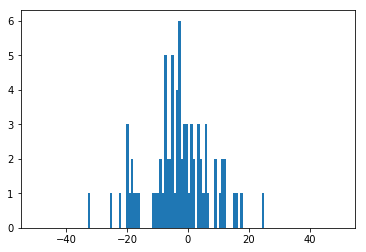

In [66]:
f, ax = plt.subplots()
h = plt.hist(sites_gdf_wa['elev_diff'], bins=128, range=(-50,50))

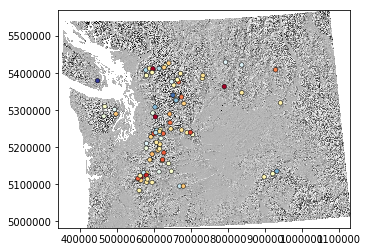

In [67]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(hs_src))
sites_gdf_wa.plot(column='elev_diff', cmap='RdYlBu', ax=ax, vmin=-30, vmax=30, s=20, edgecolor='k', lw=0.5)

## A note on sampling coarse rasters or noisy rasters at discrete locations
* The above approach is efficient, but it uses "nearest neighbor" approach to extract the elevation value for the grid cell that contains the point, regradless of where the point falls within the grid cell (center vs. corner)
* But our grid cells can be big (~90x90 m for the SRTM3 data)
* A better approach would be to use bilinear or bicubic sampling, to interpolate the elevatoin value at the point coordinates
* Another approach uses pixels within some radius of the point location, then computes stats (e.g., median elevation)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/

## Do SNOTEL sites provide a good sample for WA state hypsometry?
* Hypsometry is just total area in different elevation bins (https://en.wikipedia.org/wiki/Hypsometry)
* Plot histogram for your clipped WA DEM using a bin width of 100 m
* Overlay histogram of your SNOTEL sites using the same bins
* Do the SNOTEL sites provide a good sample of the observed WA state hypsometry? Do they need to (where does it snow)? 

# Extra credit

## Consider effects of slope and aspect on SNOTEL snow depth metrics we used in Week06 lab
* Compute slope and aspect using gdaldem
* Sample values for each SNOTEL site
* Repeat your regressoin analysis to consider relationships between snow depth vs. slope, snow depth vs. aspect, etc.

## Extract USGS National Elevation Dataset (10-m or 1/3 arcsecond) for SNOTEL sites
* Use the function below to extract NED elevations
* How do these compare with SRTM elevations?

In [53]:
#Adapted from example here: https://gist.github.com/pyRobShrk/8df3a3c422fb1c88882a5e41b284349f#file-usgs10melev-py
from http import client
def USGS10mElev(lon, lat):
    usgs = client.HTTPConnection('ned.usgs.gov')
    #https://ned.usgs.gov/epqs/pqs.php?x=-121.9295&y=48.8245&units=Meters&output=xml
    usgs.request('GET','/epqs/pqs.php?x=%.6f&y=%.6f&units=Meters&output=xml'% (lon, lat))
    result = usgs.getresponse()
    out = None
    if result.status == 200:
        xml = result.read()
        out = float(xml[xml.find(b'<Elevation>')+11:xml.find(b'</Elevation>')-1])
    return out

In [54]:
USGS10mElev(-121.9295, 48.8245)

1505.0

## Filtering
* Smoothing with gaussian filter
* Median filter

## Compute zonal statistics for watershed polygons


## Create a tile index
* Navigate to the cache directory
* Use `gdaltindex` command to create a geojson file of all `*.tif` tiles
* Load with geopandas and inspect
* More interesting/useful when you have more than two tiles